# Методы бустинга

Бустинг (англ. boosting — усиление) — композиционный метаалгоритм машинного обучения, применяется, главным образом, для уменьшения смещения (погрешности оценки), а также дисперсии в обучении с учителем. Также определяется как семейство алгоритмов машинного обучения, преобразующих слабые обучающие алгоритмы в сильные.

Бустинг основан на вопросе, поднятом Кернсом и Вэлиантом: «Может ли набор слабых обучающих алгоритмов создать сильный обучающий алгоритм?». Слабый обучающий алгоритм определяется как классификатор, который слабо коррелирует с правильной классификацией (может пометить примеры лучше, чем случайное угадывание). В отличие от слабого алгоритма, сильный обучающий алгоритм является классификатором, хорошо коррелирующим с верной классификацией.

Положительный ответ Роберта Шапире в статье 1990 года на вопрос Кернса и Вэлианта имел большое значение для теории машинного обучения и статистики, и привёл к созданию широкого спектра алгоритмов бустинга.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import daal4py

Чтение датасета, разделение на тренировочную и тестовую части и преобразование меток к виду {-1, 1} для некоторых алгоритмов

In [2]:
df = pd.read_csv('bioresponse_csv.csv')

train_data, test_data, train_labels, test_labels = train_test_split(df.loc[:, :'D1776'].to_numpy(), df.loc[:, 'target':], test_size=0.1)
print(f'train: {train_data.shape} {train_labels.shape}, test: {test_data.shape} {test_labels.shape}')

# AdaBoost and BrownBoost require 1 and -1 as labels values
train_labels_binary = np.copy(train_labels)
train_labels_binary[train_labels_binary == 0] = -1

test_labels_binary = np.copy(test_labels)
test_labels_binary[test_labels_binary == 0] = -1

train: (3375, 1776) (3375, 1), test: (376, 1776) (376, 1)


## AdaBoost

AdaBoost (сокращение от Adaptive Boosting) — алгоритм машинного обучения, предложенный Йоавом Фройндом и Робертом Шапире. Этот алгоритм может использоваться в сочетании с несколькими алгоритмами классификации для улучшения их эффективности. Алгоритм усиливает классификаторы, объединяя их в «комитет» (ансамбль). AdaBoost является адаптивным в том смысле, что каждый следующий комитет классификаторов строится по объектам, неверно классифицированным предыдущими комитетами. AdaBoost чувствителен к шуму в данных и выбросам. Однако он менее подвержен переобучению по сравнению с другими алгоритмами машинного обучения.

AdaBoost вызывает слабые классификаторы в цикле. После каждого вызова обновляется распределение весов, которые отвечают важности каждого из объектов обучающего множества для классификации. На каждой итерации веса каждого неверно классифицированного объекта возрастают, таким образом новый комитет классификаторов «фокусирует своё внимание» на этих объектах.

Обучение классификатора

In [3]:
result = daal4py.adaboost_training(nClasses=2, maxIterations=10).compute(train_data, train_labels_binary)
ada_model = result.model

print(f'Number of features: {ada_model.NFeatures}, Number of learners: {ada_model.NumberOfWeakLearners}\nInfluence of learners: {ada_model.Alpha.reshape(-1)}')

Number of features: 1776, Number of learners: 10
Influence of learners: [1.03138947 0.32982742 0.40453338 0.09933827 0.17293488 0.1474977
 0.12651275 0.17360895 0.27717742 0.25421338]


Получение предсказаний

In [4]:
result = daal4py.adaboost_prediction(nClasses=2, maxIterations=10).compute(test_data, ada_model)
ada_prediction = result.prediction

ada_prediction[ada_prediction == -1] = 0.

df_pred = pd.DataFrame(np.concatenate([test_labels, ada_prediction], 1), columns=['true_label', 'ada'])
df_pred

true_label  ada
0           0.0  0.0
1           0.0  0.0
2           0.0  0.0
3           1.0  1.0
4           1.0  1.0
..          ...  ...
371         1.0  1.0
372         0.0  1.0
373         1.0  1.0
374         1.0  1.0
375         1.0  0.0

[376 rows x 2 columns]

Оценка точности алгоритма

In [5]:
ada_accuracy = accuracy_score(df_pred.true_label, df_pred.ada)
print(f'AdaBoost accuracy: {ada_accuracy:.3f}')

AdaBoost accuracy: 0.731


# LogitBoost

LogitBoost — ещё один алгоритм бустинга. LogitBoost и AdaBoost близки друг к другу в том смысле, что оба выполняют аддитивную логистическую регрессию. Разница в том, что AdaBoost минимизирует экспоненциальные потери, тогда как LogitBoost минимизирует логистические потери.

Тренировка классификатора

In [6]:
result = daal4py.logitboost_training(nClasses=2, maxIterations=10).compute(train_data, train_labels)
logit_model = result.model

print(f'Number of features: {logit_model.NFeatures}, Number of learners: {logit_model.NumberOfWeakLearners}')

Number of features: 1776, Number of learners: 20


Получение предсказаний

In [7]:
result = daal4py.logitboost_prediction(nClasses=2, maxIterations=10).compute(test_data, logit_model)
logit_prediction = result.prediction

df_pred['logit'] = logit_prediction.reshape(-1)
df_pred

true_label  ada  logit
0           0.0  0.0    0.0
1           0.0  0.0    0.0
2           0.0  0.0    0.0
3           1.0  1.0    1.0
4           1.0  1.0    1.0
..          ...  ...    ...
371         1.0  1.0    1.0
372         0.0  1.0    1.0
373         1.0  1.0    1.0
374         1.0  1.0    1.0
375         1.0  0.0    0.0

[376 rows x 3 columns]

Оценка алгоритма

In [8]:
logit_accuracy = accuracy_score(df_pred.true_label, df_pred.logit)
print(f'LogitBoost accuracy: {logit_accuracy:.3f}')

LogitBoost accuracy: 0.745


# BrownBoost

BrownBoost — алгоритм бустинга, который показал свою эффективность на зашумленных наборах данных. Как и все алгоритмы бустинга, BrownBoost используется в сочетании с другими алгоритмами машинного обучения. Алгоритм BrownBoost был предложен Йоавом Фройндом.

Алгоритм AdaBoost показал свою эффективность на множестве наборов данных. Тем не менее можно показать, что AdaBoost не эффективен на зашумленных наборах данных. Это следствие того, что AdaBoost фокусируется на элементах обучающей выборки, которые многократно ошибочно классифицированы. В отличие от него, BrownBoost просто «сдаётся» на таких элементах. В основе BrownBoost лежит предположение, что зашумленные элементы будут многократно ошибочно классифицированы базовыми классификаторами, а незашумленные элементы будут достаточно часто корректно классифицированы. Это позволит откинуть зашумленные элементы, а незашумленные элементы внесут свой вклад в итоговый классификатор. Таким образом итоговый классификатор будет обучаться на незашумленных элементах обучающей выборки, поэтому его обобщающая способность может быть лучше, чем у AdaBoost при обучении на обучающей выборке с шумом.

Обучение классификатора

In [9]:
result = daal4py.brownboost_training(nClasses=2, maxIterations=10).compute(train_data, train_labels_binary)
brown_model = result.model

print(f'Number of features: {brown_model.NFeatures}, Number of learners: {brown_model.NumberOfWeakLearners}\nInfluence of learners: {brown_model.Alpha.reshape(-1)}')

Number of features: 1776, Number of learners: 10
Influence of learners: [0.29759321 0.09723874 0.12625214 0.02978711 0.09591432 0.03672385
 0.05386348 0.04176517 0.04250818 0.08102705]


Получение предсказаний

In [10]:
result = daal4py.brownboost_prediction(nClasses=2, maxIterations=10).compute(test_data, brown_model)
brown_prediction = np.sign(result.prediction)

brown_prediction[brown_prediction == -1] = 0.

df_pred['brown'] = brown_prediction.reshape(-1)
df_pred

true_label  ada  logit  brown
0           0.0  0.0    0.0    0.0
1           0.0  0.0    0.0    0.0
2           0.0  0.0    0.0    0.0
3           1.0  1.0    1.0    1.0
4           1.0  1.0    1.0    1.0
..          ...  ...    ...    ...
371         1.0  1.0    1.0    1.0
372         0.0  1.0    1.0    1.0
373         1.0  1.0    1.0    1.0
374         1.0  1.0    1.0    1.0
375         1.0  0.0    0.0    0.0

[376 rows x 4 columns]

Оценка алгоритма

In [11]:
brown_accuracy = accuracy_score(df_pred.true_label, df_pred.brown)
print(f'LogitBoost accuracy: {brown_accuracy:.3f}')


LogitBoost accuracy: 0.734


Сравнение оценок

In [12]:
accuracy = pd.DataFrame([[ada_accuracy, logit_accuracy, brown_accuracy]], columns=['ada', 'logit', 'brown'])
accuracy


ada     logit     brown
0  0.731383  0.744681  0.734043

Определение зависимости точности классификации алгоритма BrownBoost от числа итераций

<AxesSubplot: xlabel='n_iter'>

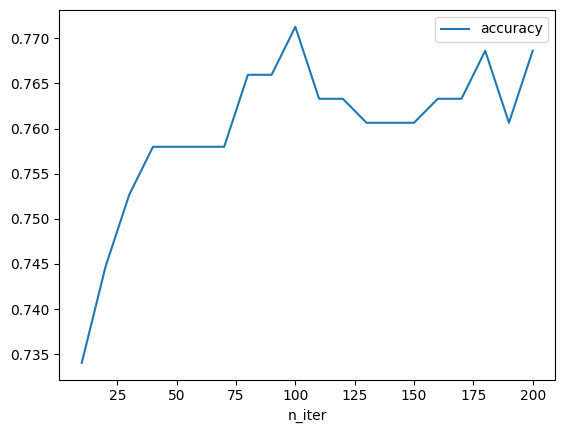

In [13]:
accuracies = []

for n_iter in range(10, 201, 10):
    model = daal4py.brownboost_training(nClasses=2, maxIterations=n_iter).compute(train_data, train_labels_binary).model
    prediction = np.sign(daal4py.brownboost_prediction(nClasses=2, maxIterations=n_iter).compute(test_data, model).prediction)
    score = accuracy_score(test_labels_binary, prediction)
    accuracies.append((n_iter, score))

acc_df = pd.DataFrame(accuracies, columns=['n_iter', 'accuracy'])
acc_df.plot(x='n_iter', y='accuracy')
